In [1]:
import sys
sys.path.append('/home/vitorbordini/Downloads/self_learn_ivp')
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,KFold
from sklearn.isotonic import IsotonicRegression
from sklearn.datasets import load_digits,load_wine,load_iris
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from collections import OrderedDict
import tensorflow as tf

import tkinter as tk
from PIL import ImageTk, Image
from os import listdir

#from neural_net import SimpleNeuralNet, SimpleNeuralNetCredal
#from utils import MyDataset, plot_decision_boundary
from optimistic_solver import solve
from datasets import *

2023-07-19 13:19:39.140827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:19:39.337689: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 13:19:39.972282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-19 13:19:39.972388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def load_planar_dataset(n_example: int,num_classes:int):
    """Create and return a mock dataset. If we plot the data, we can see
    a sort of flower. The created dataset contains n_example X of 2 features
    and their associated label

    Args:
        n_example (int): number of examples in the wanted dataset

    Returns:
        Tuple[np.ndarray, np.ndarray]: Features matrix and associated labels vector
    """
    np.random.seed(1)
    n_representation = int(n_example/num_classes)
    n_features = 2
    features = np.zeros((n_example, n_features))
    labels = np.zeros((n_example,1), dtype='uint8')
    max_ray = 4
    for label in range(num_classes):
        index = range(n_representation*label,n_representation*(label+1))
        theta = np.linspace(
            label*3.12,(label+1)*3.12,n_representation
        ) + np.random.randn(n_representation)*0.2
        radius = max_ray*np.sin(4*theta) + np.random.randn(n_representation)*0.2
        features[index] = np.c_[radius*np.sin(theta), radius*np.cos(theta)]
        labels[index] = label
    data = dict()
    data['target'] = labels
    data['data'] = features
    return data

In [3]:
def one_hot(vector,num_classes=3):
    vector = vector.squeeze()
    b = np.zeros((vector.size,num_classes))
    b[np.arange(vector.size), vector] = 1
    return b

In [4]:
data = load_digits()
X,y = data['data'],data['target']
X = normalize(X)
num_classes = np.max(y)+1

n_input = X.shape[1]
n_hidden_units = n_input
y = one_hot(y,num_classes=num_classes).squeeze()
X,y = shuffle(X,y)

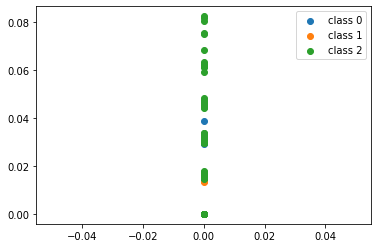

In [5]:
indexes = np.where(y[:,0]==1)[0]
plt.scatter(X[indexes,0],X[indexes,1])

indexes = np.where(y[:,1]==1)[0]
plt.scatter(X[indexes,0],X[indexes,1])

indexes = np.where(y[:,2]==1)[0]
plt.scatter(X[indexes,0],X[indexes,1])

plt.legend(['class 0','class 1','class 2'])

In [6]:
class MyDataset(torch.utils.data.Dataset):
    # defining values in the constructor
    def __init__(self,x_train,y_train):
        self.x= x_train.astype(np.float32)
        self.y = y_train.astype(np.float32)
        self.len = len(self.y)
     
    # Getting the data samples
    def __getitem__(self, idx):
        sample = self.x[idx], self.y[idx]
        return sample
    
    # Getting data size/length
    def __len__(self):
        return self.len

In [7]:
class SimpleNeuralNet(nn.Module):
    """Simple Neural Network (with 1 hidden layer) used for tests.
    Only use for binary classification and for hard or soft labels
    """
    def __init__(self, clipping_value: float, n_input_units: int, n_hidden_units: int,num_classes=10):
        """Initialisation of the neural network

        Args:
            clipping_value (float): clipping value to avoid exploding gradient
            n_input_units (int): number of neurons for the input layer
            n_hidden_units (int): number of neurons for the hidden layer
        """
        super().__init__()
        
        self.input_layer = nn.Sequential(
            OrderedDict(
                {
                    'linear': nn.Linear(in_features=n_input_units, out_features=n_hidden_units),
                     #'relu': nn.ReLU(inplace=True),
                }
            )
        )
        
        self.hidden_layer = nn.Linear(in_features=n_hidden_units, out_features=num_classes)
        self.num_classes = num_classes
        self.output_layer = nn.Softmax(dim=1)
        self.losses = {}
        self.accuracies = {}
        self.clipping_value = clipping_value

    def forward(self, x_train: torch.Tensor) -> torch.Tensor:
        """Computes the forward propagation

        Args:
            x (torch.Tensor): Features used

        Returns:
            torch.Tensor: probabilities output by the neural network
        """
        y_pred = self.input_layer(x_train)
        y_pred = self.hidden_layer(y_pred)      
        y_pred = self.output_layer(y_pred)
        return y_pred

    def __initiate_loss_and_accuracy_dicts(self, n_epochs: int):
        """initiate loss and accuracy dictionnaries to keep track of performances

        Args:
            n_epochs (int): number of epochs during learning
        """
        for i in range(n_epochs):
            self.losses[i] = 0
            self.accuracies[i] = 0

    def fit(
        self,
        x_train: pd.DataFrame,
        y_train: pd.Series,
        epochs: int,
        learning_rate: float,
        verbose=True,
        soft=False
    ):
        """Fit the neural network to the data

        Args:
            x_train (pd.DataFrame): Learning features
            y_train (pd.Series): Learning labels
            epochs (int): number of epochs for training
            learning_rate (float): learning rate for gradient descent
            verbose (bool, optional): Print the training informations as tensorflow does.
                Defaults to True.
            soft (bool, optional): True if y_train is composed of soft labels, else False.
                Defaults to False.
        """
        self.__initiate_loss_and_accuracy_dicts(n_epochs=epochs)
        myDs=MyDataset(x_train=x_train, y_train=y_train)
        train_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        for epoch in range(epochs):
            n_batches = len(train_loader)
            if verbose:
                print(f'Epoch {epoch+1}/{epochs}')
                pbar = tf.keras.utils.Progbar(target=n_batches)
            for idx, batch in enumerate(train_loader):
                x, y = batch
                optimizer.zero_grad()
                
                outputs = self(x)
                outputs = torch.where(outputs>0.999, outputs-0.001, outputs)
                outputs = torch.where(outputs<0.001, outputs+0.001, outputs)
                
                y = torch.where(y>0.999, y-0.001, y)
                y = torch.where(y<0.001, y+0.001, y)
                
                loss_value = (y*(y.log()-outputs.log())).sum(dim=1).mean()#nn.KLDivLoss(reduction='batchmean')
                #loss_value = loss(y_one.float(),outputs) #KLD_loss(y, outputs)
                torch.nn.utils.clip_grad_norm_(self.parameters(), self.clipping_value)
                loss_value.backward()
                optimizer.step()
                if not soft:
                    accuracy = accuracy_score(
                        y_true=np.argmax(y,axis=1),
                        y_pred=torch.argmax(outputs,dim=1).detach().numpy()
                    )
                    self.accuracies[epoch] += accuracy
                self.losses[epoch] += loss_value.detach().numpy()
                if verbose:
                    pbar.update(
                        idx,
                        values=[
                            ("loss", loss_value.detach().numpy()),
                             ("accuracy", accuracy)
                        ]
                    )
            self.losses[epoch] = self.losses[epoch]/n_batches
            self.accuracies[epoch] = self.accuracies[epoch]/n_batches
            if verbose:
                pbar.update(n_batches, values=None)

    def predict_proba(
        self,
        x: torch.Tensor,
        as_numpy=True,
        from_numpy=True
    ) -> np.ndarray:
        """Compute forward propagation after training to obtain probabilities P(Y=1|X=x)

        Args:
            x (Union[pd.DataFrame, torch.Tensor]): Input features
            as_numpy (bool, optional): If the output type need to be a numpy array.
                Defaults to False.
            from_numpy (bool, optional): If the input features are of type numpy.ndarray.
                Defaults to True.

        Returns:
            Union[torch.Tensor, np.ndarray]: probabilities P(Y=1|X=x) estimated by the
                neural network
        """
        if from_numpy:
            x = torch.tensor(x, dtype=torch.float32)
        outputs = self(x)
        if as_numpy:
            outputs = outputs.detach().numpy()
        return outputs

In [8]:
from sklearn.neighbors import KNeighborsClassifier
def nn_v1(y_cal,calibration_probabilities,num_classes):
    taxon='v1'
    calibration_predictions=np.argmax(calibration_probabilities,axis=1)
    #print(np.sum(calibration_predictions==y_cal)/len(y_cal))
    category_distributions=np.zeros((num_classes,num_classes))
    for i in range(len(calibration_predictions)):
        category_distributions[calibration_predictions[i],y_cal[i]]+=1
    return category_distributions

def nn_v2(y_cal,calibration_probabilities,num_classes):
    taxon='v2'
    calibration_predictions=np.argmax(calibration_probabilities,axis=1)
    calibration_prediction_probs=np.max(calibration_probabilities,axis=1)

    category_distributions=np.zeros((2*num_classes,num_classes))
    for i in range(len(calibration_predictions)):
        category_distributions[calibration_predictions[i]*2+(calibration_prediction_probs[i]>0.75),y_cal[i]]+=1
    return category_distributions

def nn_v3(y_cal,calibration_probabilities,num_classes):
    taxon='v3'
    calibration_predictions=np.argmax(calibration_probabilities,axis=1)
    calibration_prediction_probs=np.max(calibration_probabilities,axis=1)
    sorted_probs=np.sort(calibration_probabilities,axis=1)
    second_highest_probs=sorted_probs[:,-2]

    category_distributions=np.zeros((2*num_classes,num_classes),dtype='int')
    for i in range(len(calibration_predictions)):
        category_distributions[calibration_predictions[i]*2+(second_highest_probs[i]>0.25),y_cal[i]]+=1
    return category_distributions

def nn_v4(y_cal,calibration_probabilities,num_classes):
    taxon='v4'
    calibration_predictions=np.argmax(calibration_probabilities,axis=1)
    calibration_prediction_probs=np.max(calibration_probabilities,axis=1)
    sorted_probs=np.sort(calibration_probabilities,axis=1)
    second_highest_probs=sorted_probs[:,-2]

    category_distributions=np.zeros((2*num_classes,num_classes),dtype='int')
    for i in range(len(calibration_predictions)):
        category_distributions[calibration_predictions[i]*2+(calibration_prediction_probs[i]-second_highest_probs[i]>0.5),y_cal[i]]+=1
    return category_distributions

def knn_v1(train_embeds,y_train,calibration_embeds,y_cal,num_classes):
    taxon='knn_v1'
    neigh = KNeighborsClassifier(n_neighbors=6, metric="euclidean")
    neigh.fit(train_embeds, y_train)
    calibration_predictions=neigh.predict(calibration_embeds)

    category_distributions=np.zeros((num_classes,num_classes),dtype='int')
    for i in range(num_classes):
        for j in range(num_classes):
            category_distributions[i,j]=np.count_nonzero(y_cal[calibration_predictions==i]==j)
    return category_distributions

def knn_v2(train_embeds,y_train,calibration_embeds,y_cal,num_classes):
    taxon='knn_v2'
    neigh = KNeighborsClassifier(n_neighbors=6, metric="euclidean")
    neigh.fit(train_embeds, y_train)
    calibration_predictions=neigh.predict(calibration_embeds)
    neigh_ind=neigh.kneighbors(calibration_embeds,return_distance=False)
    neigh_labels=y_train[neigh_ind]

    num_categories=(6//2+1)*num_classes
    category_distributions=np.zeros((num_categories,num_classes),dtype='int')
    for i in range(len(calibration_embeds)):
        category_distributions[calibration_predictions[i]*(6//2+1)+np.count_nonzero(neigh_labels[i]!=calibration_predictions[i])][y_cal[i]]+=1

    return category_distributions

def nc_v1(train_embeds,y_train,calibration_embeds,y_cal,num_classes):
    taxon='nc_v1'
    embeddings_size = train_embeds.shape[1]
    centroids=np.empty((num_classes,embeddings_size))
    for i in range(num_classes):
        centroids[i]=np.mean(train_embeds[y_train==i],axis=0)
    
    category_distributions=np.zeros((num_classes,num_classes),dtype='int')
    temp_distances=np.zeros(num_classes)
    for i in range(len(calibration_embeds)):
        for j in range(num_classes):
            temp_distances[j]=np.linalg.norm(calibration_embeds[i]-centroids[j])
        category_distributions[np.argmin(temp_distances)][y_cal[i]]+=1

    return category_distributions

def nc_v2(train_embeds,y_train,calibration_embeds,y_cal,num_classes):
    taxon='nc_v2'
    embeddings_size = train_embeds.shape[1]
    centroids=np.empty((num_classes,embeddings_size))
    for i in range(num_classes):
        centroids[i]=np.mean(train_embeds[y_train==i],axis=0)

    category_distributions=np.zeros((2*num_classes,num_classes),dtype='int')
    temp_distances=np.zeros(num_classes)
    for i in range(len(calibration_embeds)):
        for j in range(num_classes):
            temp_distances[j]=np.linalg.norm(calibration_embeds[i]-centroids[j])
        pred=np.argmin(temp_distances)
        dist=np.min(temp_distances)
        category_distributions[2*pred+int(dist>0.08)][y_cal[i]]+=1

    return category_distributions

def nn2_nc2(train_embeds,y_train,x_cal,calibration_embeds,y_cal,classifier_model,num_classes):
    embeddings_size = train_embeds.shape[1]
    centroids=np.empty((num_classes,embeddings_size))
    for i in range(num_classes):
        centroids[i]=np.mean(train_embeds[y_train==i],axis=0)

    calibration_probabilities=classifier_model.predict_proba(x_cal)
    calibration_predictions=np.argmax(calibration_probabilities,axis=1)
    calibration_prediction_probs=np.max(calibration_probabilities,axis=1)

    num_nc2_categories=2*num_classes
    num_nn2_categories=2*num_classes
    category_distributions=np.zeros((num_nc2_categories*num_nn2_categories,num_classes),dtype='int')

    temp_distances=np.zeros(num_classes)
    for i in range(len(calibration_embeds)):
        nn2_c=calibration_predictions[i]*2+(calibration_prediction_probs[i]>0.75)
        for j in range(num_classes):
            temp_distances[j]=np.linalg.norm(calibration_embeds[i]-centroids[j])
        pred=np.argmin(temp_distances)
        dist=np.min(temp_distances)
        nc2_c=2*pred+int(dist>0.08)
        category_distributions[nc2_c*num_nn2_categories+nn2_c][y_cal[i]]+=1

    return category_distributions

In [9]:
def venn_prediction(new_point,X_cal,y_cal,clf,taxon_func):
    
    X_new = np.vstack((X_cal,new_point))
    num_classes = y_cal.shape[1]
    y_cal = np.argmax(y_cal,axis=1).reshape((-1,1))
    venn_pred = np.zeros((num_classes,num_classes))
    taxonomies_cal = taxon_func(y_cal.flatten(),clf.predict_proba(X_cal),num_classes)
    for i in range(num_classes):
        y_new = np.vstack((y_cal,np.array([i])))
        taxonomies = taxon_func(y_new.flatten(),clf.predict_proba(X_new),num_classes)
        diff = taxonomies - taxonomies_cal
        idx = np.where(diff==1)[0][0]
        venn_pred[i] = taxonomies[idx]/np.sum(taxonomies[idx])
    return venn_pred

In [10]:
import cvxpy as cp
print(cp.installed_solvers())
def solve_cvx(upper,lower,pred,np):
    p = cp.Variable(upper.shape)
    prob = cp.Problem(cp.Minimize(cp.sum(cp.rel_entr(p,pred))),
                 [p<=upper,p>=lower,cp.sum(p)==1])
    prob.solve(solver='CVXOPT')
    return prob.value,p.value

['CBC', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLOP', 'GLPK', 'GLPK_MI', 'GUROBI', 'MOSEK', 'OSQP', 'PDLP', 'SCIPY', 'SCS']


In [ ]:
def self_learn(X,y,taxonomy=None,st='soft',lr=0.05,epochs=50,iterations=30):
    '''
    Self-training algorithm
        Args:
            X(ndarray, shape (N,M)): inputs
            y(ndarray, shape (N,)): outputs (hard labels)
            taxonomy(function): Venn taxonomy in case of IVP.
            lr(float): learning rate for training.
            st(string): Strategy implemented.
            epochs(int): Number of epochs to train the model on each iteration.
            iterations(int): Number of maximum iterations.
    '''
    split = 100
    seeds = [2,13,25,42,57,64,78,85,96]
    accuracies = np.zeros((iterations,len(seeds)))
    num_classes = y.shape[1]
    rep_per_class= 2
    cred_size = num_classes*rep_per_class
    for i,seed in enumerate(seeds):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=seed)

        model = SimpleNeuralNet(0.01,n_input,n_hidden_units,num_classes)
        X_labeled,y_labeled = X_train[:split],y_train[:split]
        X_unlabeled = X_train[split:]

        prop = int(len(X_unlabeled)/iterations)
        if st == 'credal':
            indexes = np.zeros((num_classes*rep_per_class)).astype(int)
            for cl in range(num_classes):
                indexes[cl] = np.where(y_labeled[:,cl]==1)[0][:rep_per_class]
            X_cal,y_cal = X_labeled[indexes],y_labeled[indexes]
            X_labeled = np.delete(X_labeled,indexes,0)
            y_labeled = np.delete(y_labeled,indexes,0)
            X_cal,y_cal = shuffle(X_cal,y_cal)

        model.fit(X_labeled,y_labeled,epochs,lr,verbose=False)
        for j in range(iterations):            
            if st =='hard':
                y_unlabeled = model.predict_proba(X_unlabeled)
                y_unlabeled = np.expand_dims(np.argmax(y_unlabeled,axis=1),axis=1)
                y_unlabeled = one_hot(y_unlabeled,num_classes).squeeze()
                y_unlabeled = y_unlabeled[j*prop:(j+1)*prop]
                y_acc = np.vstack((y_labeled,y_unlabeled))
                X_acc = np.vstack((X_labeled,X_unlabeled[j*prop:(j+1)*prop]))
            elif st=='credal':
                y_unlabeled = model.predict_proba(X_unlabeled)
                for k in range(len(X_unlabeled)):
                    venn_pred = venn_prediction(X_unlabeled[k],X_cal,y_cal,model,nn_v1)
                    upper = np.max(venn_pred,axis=0)
                    lower = np.min(venn_pred,axis=0)
                    _,p_opt = solve_cvx(upper,lower,y_unlabeled[k],np)
                    y_unlabeled[k] = p_opt

                y_acc = np.vstack((y_labeled,y_unlabeled))
                X_acc = np.vstack((X_labeled,X_unlabeled))
            elif st == 'soft':
                y_unlabeled = model.predict_proba(X_unlabeled)
                y_acc = np.vstack((y_labeled,y_unlabeled))
                X_acc = np.vstack((X_labeled,X_unlabeled))

            model.fit(X_acc,y_acc,epochs,lr,verbose=False)
            accuracies[j,i] = accuracy_score(y_true=np.argmax(y_test,axis=1),
                                          y_pred=torch.argmax(model(torch.from_numpy(X_test).float()),dim=1).detach().numpy())
    return accuracies

def compare_self_learn(X,y,iterations):
    acc_hard = self_learn(X,y,st='hard',iterations=iterations)
    acc_hard = np.mean(acc_hard,axis=1)
    
    acc_soft = self_learn(X,y,st='soft',iterations=iterations)
    acc_soft = np.mean(acc_soft,axis=1)
    
    acc_cred = self_learn(X,y,st='credal',iterations=iterations)
    acc_cred = np.mean(acc_cred,axis=1)

    
    print(acc_hard)
    print(acc_soft)
    print(acc_cred)
    
    plot = pd.DataFrame({'credal':acc_cred})
    #plot = pd.DataFrame({'hard':acc_hard, 'soft':acc_soft, 'credal':acc_cred})
    sns.lineplot(data=plot).set(title="Accuracy")
    plt.savefig('result_digits_{}'.format(20))

compare_self_learn(X,y,iterations=30)

In [11]:
def prob2xy(p1,p2,p3):
    return p1,p2#[p3/(1-p3)*p2+(1-p3)/2,(1-p3)/2]
    

def plot_point(bounds,predictions,p_opt,i):
    tri = np.array([[0,0],[1,0],[0,1]])
    
    upper = np.max(bounds,axis=0)
    lower = np.min(bounds,axis=0)
    
    plt.figure()
    
    plt.plot(tri[:-1,0],tri[:-1,1],color='blue',label='Domain')
    plt.plot(tri[1:,0],tri[1:,1],color='blue')
    plt.plot([tri[0,0],tri[2,0]],[tri[0,1],tri[2,1]],color='blue')
    
    x_pred,y_pred = prob2xy(predictions[0],predictions[1],predictions[2])
    
    point1 = prob2xy(upper[0],lower[1],lower[2])
    point2 = prob2xy(lower[0],upper[1],lower[2])
    point3 = prob2xy(lower[0],lower[1],upper[2])
    
    p_point= prob2xy(p_opt[0],p_opt[1],p_opt[2])
    
    tri_upper = np.array([point1,point2,point3])
    
    plt.scatter(tri_upper[:, 0], tri_upper[:, 1])
    
        
    t2 = plt.Polygon(tri_upper, color='red',label='Credal Set')
    plt.gca().add_patch(t2)
    
    plt.scatter([x_pred],[y_pred],s=100,label='Prediction')
    plt.scatter([p_point[0]],[p_point[1]],s=100,label='Optimal p')
    
    plt.legend()#['Domain','upper bounds','credal set','prediction','optimal p'])
    #plt.savefig('point_iris/img_'+str(i))
    #plt.xlim([0,1])
    #plt.ylim([0,0.6])
#plot_point(venn_pred,predictions,p_opt)

ERROR! Session/line number was not unique in database. History logging moved to new session 192


<ipython-input-13-924b22aeb753>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


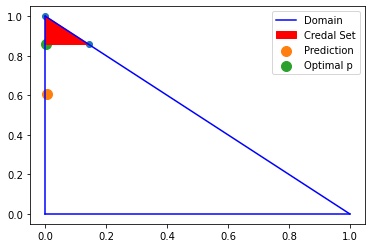

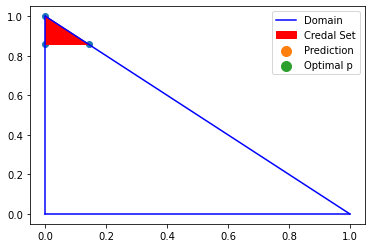

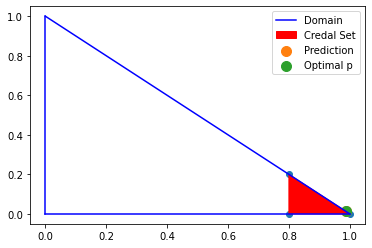

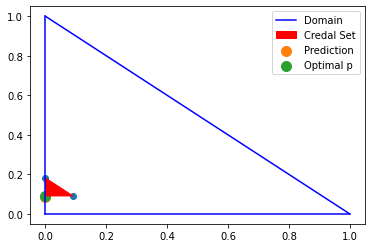

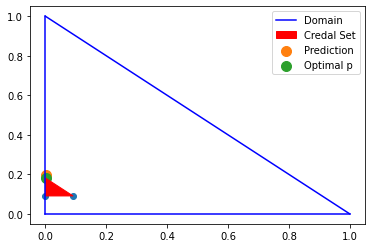

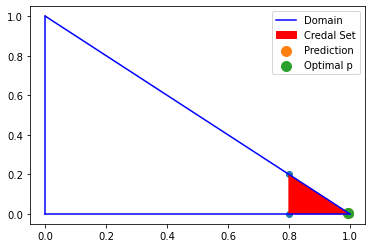

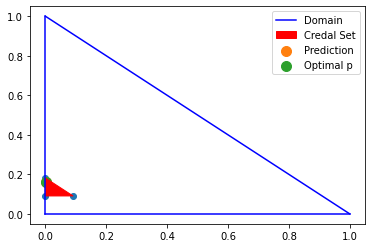

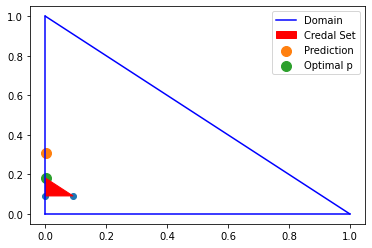

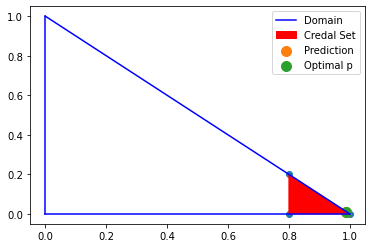

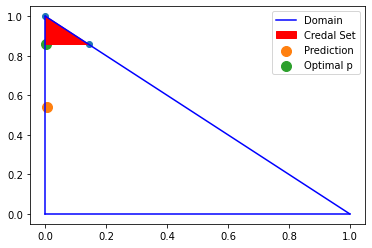

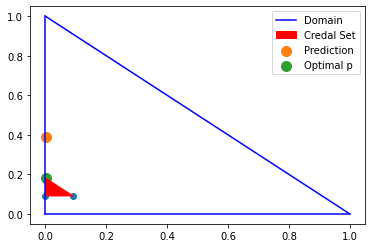

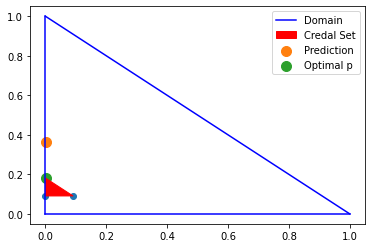

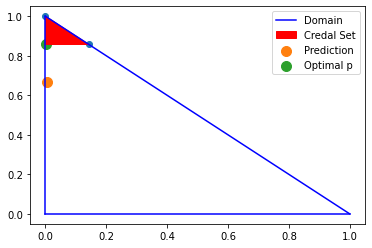

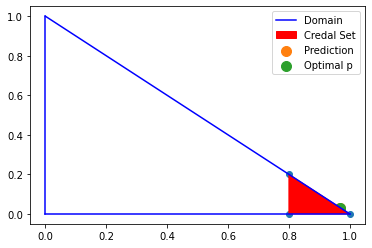

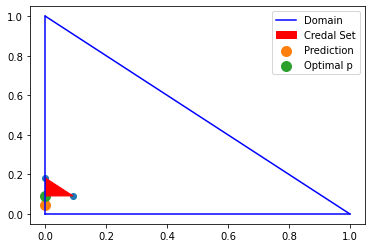

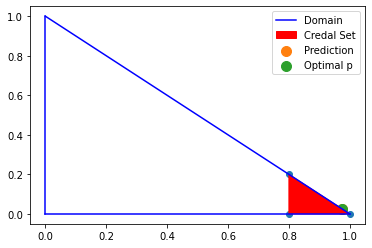

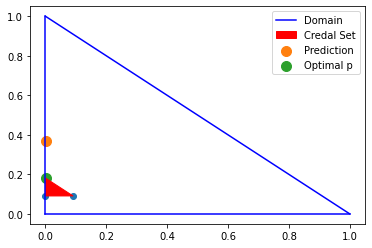

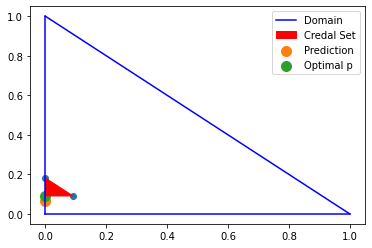

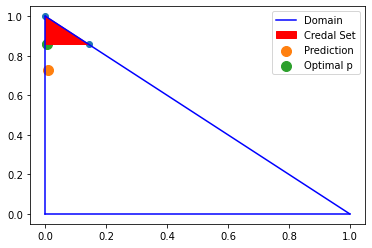

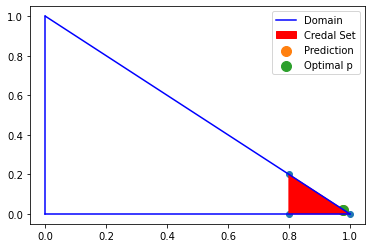

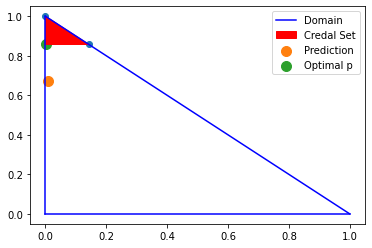

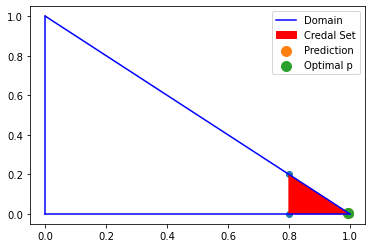

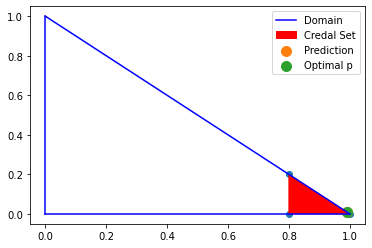

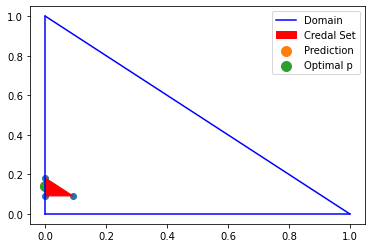

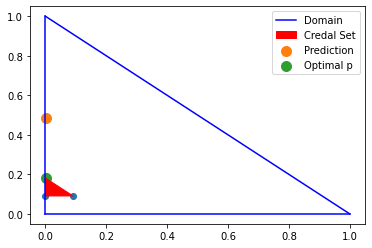

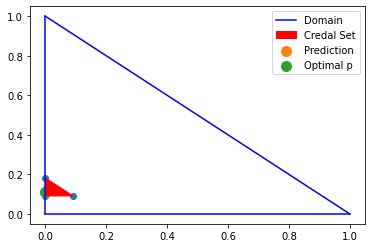

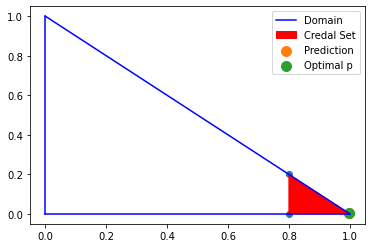

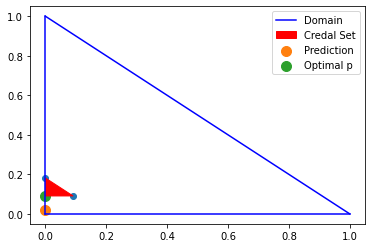

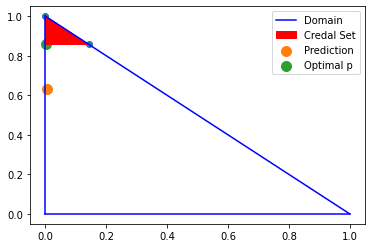

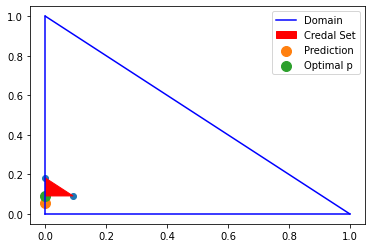

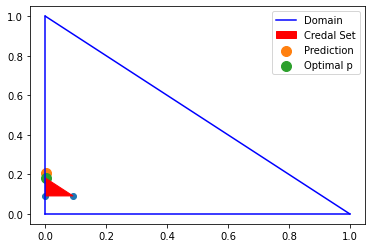

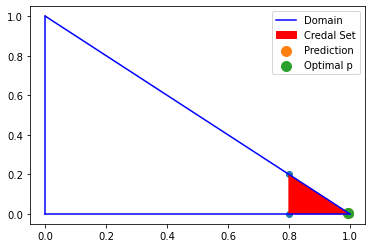

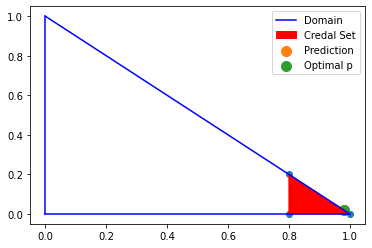

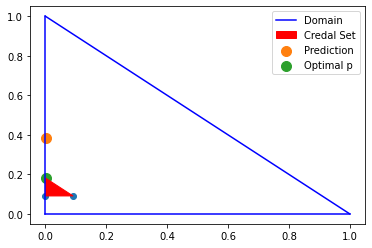

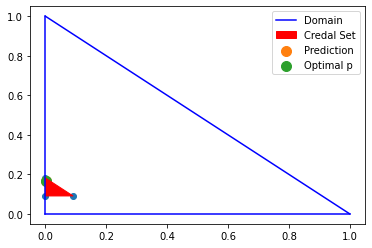

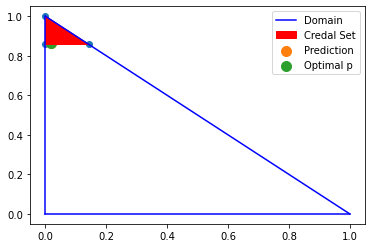

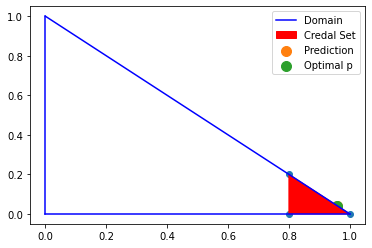

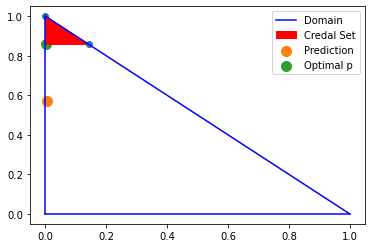

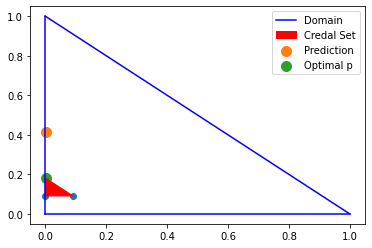

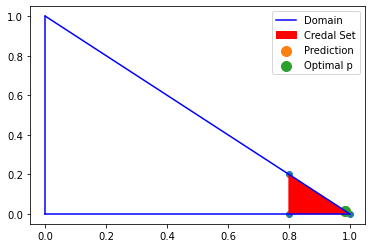

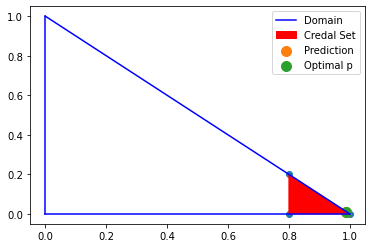

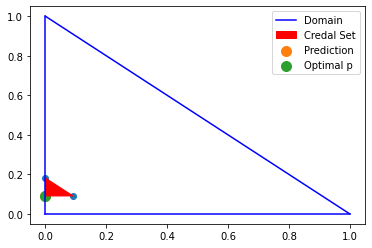

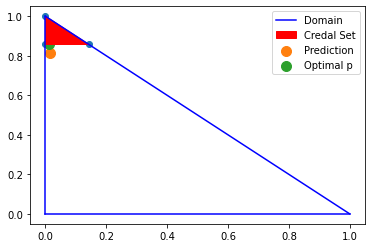

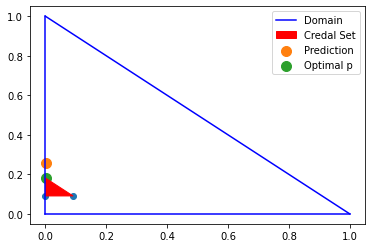

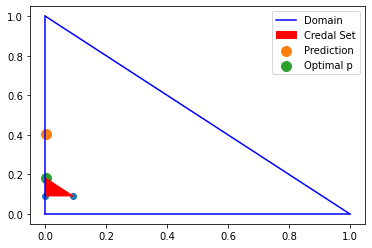

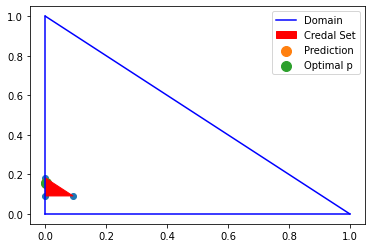

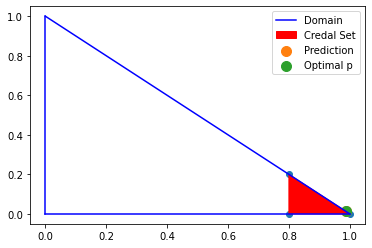

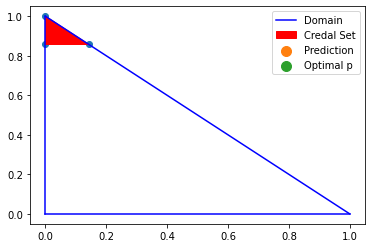

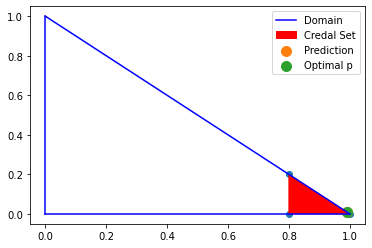

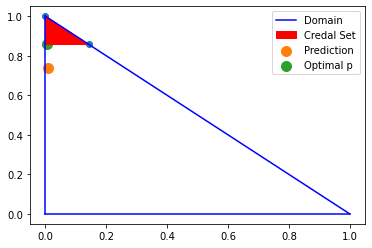

In [16]:
predictions = clf.predict_proba(X_test)
for i in range(len(X_test)):
    venn_pred = venn_prediction(X_test[i],X_cal,y_cal,clf,nn_v1)
    upper = np.max(venn_pred,axis=0)
    lower = np.min(venn_pred,axis=0)
    if all(np.logical_and(predictions[i]<upper,predictions[i]>lower)):
        p_opt=predictions[i]
    else:
        _,p_opt =solve_cvx(upper,lower,predictions[i],np)
    plot_point(venn_pred,predictions[i],p_opt,i)    

In [13]:
size= 700, 700

window = tk.Tk()
window.title("Join")
window.geometry("700x700")
window.minsize(700,700)
window.maxsize(700,700)

bottomFrame = tk.Frame(window)
bottomFrame.pack(fill=tk.X, side=tk.BOTTOM)

for i in range(2):
    bottomFrame.columnconfigure(i, weight=1)

    
imagesList = listdir("point_img/")
#commands
def next_image():
    global im, img, path
    if len(imagesList) > 0:
        path = imagesList.pop(0) # extract a image path from the list
        im = Image.open(src_dir + path)
        im.thumbnail(size, Image.ANTIALIAS)
        img = ImageTk.PhotoImage(im)
        label.config(image=img)
    else:
        label.config(text="No more image!", image="")

def nex():
    next_image() # show next image

def previous():
    next_image() # show next image

src_dir = "point_img/"
imagesList = listdir(src_dir) # load the image list

# label for showing the image
label = tk.Label(window)
label.pack(side = "top", fill="both", expand="true")

bluebutton = tk.Button(bottomFrame, text="one", fg="blue", command=nex)
bluebutton1 = tk.Button(bottomFrame, text="two", fg="blue", command=previous)

bluebutton.grid(row=0, column=0, sticky=tk.W+tk.E)
bluebutton1.grid(row=0, column=1, sticky=tk.W+tk.E)

# show the first image
next_image()
window.mainloop()
